In [2]:
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# Wstęp

Zadanie 11 jest drugą częścią do zajęć laboratoryjnych poświęconych sieciom rekurencyjnym i predykcji z wykorzystaniem danych multimodalnych. Efektem prac będzie sieć rekurencyjna do predykcji kursu kryptowaluty Bitcoin (BTC) w oparciu o dane z giełdy oraz o wyniki analizy emocji komunikatów z mediów społecznościowych, do których również należy utworzyć dedykowany model sieci rekurencyjnej. Plan realizacji etapów wygląda następująco:

1.  EmoTweet - model sieci rekurencyjnej do analizy emocji (10 pkt., laboratorium 10)
2.  Agregacja informacji emotywnej i przygotowanie MultiBTC - multimodalnego model sieci rekurencyjnej do predykcji kursu BTC (10 pkt., laboratorium 11)
3.  Ewaluacja modelu MultiBTC (10 pkt., laboratorium 12)

Łącznie można otrzymać 30 punktów.

# Cel ćwiczenia

Celem drugiego etapu prac jest przygotowanie modelu MultiBTC sieci rekurencyjnej LSTM do przewidywania kolejnego elementu sekwencji pod warunkiem wcześniejszych obserwacji. Dopuszczalne jest rozwiązanie, które działa podobnie jak klasyfikator z poprzedniego zadania, przy czym w tym wypadku skonstruowany zostanie regresor, a zmienną predykowaną będzie np. średni kurs w następnym dniu pod warunkiem obserwacji z dni poprzednich.

# Warunki zaliczenia

Do zaliczenia drugiego etapu należy wykonać następujące kroki:

1.  Klasyfikacja zbioru tweetów przy pomocy 2 modeli EmoTweet opracowanych w etapie nr 1 (gdyby sieci LSTM były zbyt wolne, można użyć modeli opartych o fastText).
2.  Przygotowanie modelu LSTM, dla którego każdy element sekwencji będzie multimodalny, tj. będzie opisany cechami pochodzącymi z różnych źródeł:

- Dane z giełdy kryptowalutowej
- Zagregowane wartości emocji z tweetów

# Zbiór tweetów

Zbiór tweetów pochodzi z serwisu [Twitter](https://twitter.com/) i jest podzbiorem 2 milionów wiadomości dotyczących [Bitcoina](https://en.wikipedia.org/wiki/Bitcoin) z okresu od stycznia 2018 do maja 2020 roku.

## Pobranie


In [3]:
# należy wgrać plik z katalogu "dane" o nazwie bitcoin_tweets_2M.csv.7z

## Rozpakowanie


In [2]:
!7za x bitcoin_tweets_2M.csv.7z

/bin/bash: line 1: 7za: command not found


## Zawartość

Dane zawierają następujące kolumny:

- `timestamp` - data wysłania wiadomości
- `likes` - liczba polubień wiadomości
- `retweets` - liczba przekazań dalej wiadomości
- `username` - nick użytkownika
- `text` - tekst tweeta "zanonimizowany" przy pomocy metody [`preprocess`](https://github.com/cardiffnlp/tweeteval/blob/main/TweetEval_Tutorial.ipynb), która była użyta przy tworzeniu zbioru [TweetEval](https://github.com/cardiffnlp/tweeteval)


In [11]:
# for server
import os

# os.chdir("/home")

# for local

print(os.getcwd())

/home/piotr/projects/ai/gsn-l/lab-11


In [84]:
tweets_data = pd.read_csv("bitcoin_tweets_2M.csv")
tweets_data

,timestamp,likes,retweets,username,text
0,2018-01-01 00:00:03,0,0,ANDRO1711,"From the future of bitcoin to Facebook, 2018 i..."
1,2018-01-01 00:00:04,2,3,BitcoinAverage - Cryptocurrency Exchange Rates,BitcoinAverage - bitcoin price index - ($ 1394...
2,2018-01-01 00:00:09,0,0,Jimmyhoshi,Singapore bar offers bitcoin New Year party pa...
3,2018-01-01 00:00:16,0,0,BTC Bros,how the Chinese bitcoin market collapsed in 20...
4,2018-01-01 00:00:26,1,1,SBIYP,Cryptocurrency Craze! #bitcoin #ethereum #dash...
...,...,...,...,...,...
2454286,2020-05-29 23:57:21,1,0,𝙂𝙧𝙞𝙢,"All good till now man, hope all is well there ..."
2454287,2020-05-29 23:57:48,0,0,Digital Asset Controller,It’s just used as a wedge to divid the people ...
2454288,2020-05-29 23:58:10,0,0,(CEO of MONEY PRINTERS),is this sweat... oh wait just underwater with ...
2454289,2020-05-29 23:58:43,2,0,luke,The whole timing of this virus is very suspici...


# Dane z giełdy [Bitstamp](https://www.bitstamp.net/)

Zbiór pochodzi z serwisu Bitstamp i zawiera informacje o kursie Bitcoina od stycznia 2017 roku do kwietnia 2021 roku, zarówno w interwałach jednodniowych (24h), jak też godzinowych (1h).

## Pobranie


In [8]:
# należy wgrać plik z katalogu "dane" o nazwie bitstamp.7z

## Rozpakowanie


In [12]:
!7za x bitstamp.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,16 CPUs AMD Ryzen 7 4700U with Radeon Graphics          (860F01),ASM,AES-NI)

Scanning the drive for archives:
  0M Sca        1 file, 773846 bytes (756 KiB)

Extracting archive: bitstamp.7z
--
Path = bitstamp.7z
Type = 7z
Physical Size = 773846
Headers Size = 221
Method = LZMA2:3m
Solid = +
Blocks = 1

    Everything is Ok

Files: 2
Size:       3036393
Compressed: 773846


## Zawartość

Kwoty są podane w dolarach amerykańskich (kurs BTC/USD). Daty wyznaczają moment zamknięcia, a momentem otwarcia jest godzina wstecz (wariant 1h) lub dzień wstecz (wariant 24h). Każdy ze zbiorów zawiera następujące kolumny:

- `timestamp` - data w [formacie Unix](https://www.epochconverter.com/)
- `date` - j.w. w formacie YYYY-MM-DD HH:MM:SS
- `open` - kurs otwarcia
- `high` - najwyższa wartość
- `low` - najniższa wartość
- `close` - kurs zamknięcia
- `volume` - wolumen obrotu BTC

Interwał godzinowy:


In [4]:
bitstamp_data_1h = pd.read_csv("Bitstamp_BTCUSD_1h_2017_2018_2019_2020_2021-04-08.csv")
bitstamp_data_1h

,timestamp,date,open,high,low,close,volume
0,1483228800,2017-01-01 00:00:00,966.34,966.99,964.60,966.60,102.484806
1,1483232400,2017-01-01 01:00:00,966.60,966.60,962.54,963.87,149.025554
2,1483236000,2017-01-01 02:00:00,964.35,965.75,961.99,963.97,94.267396
3,1483239600,2017-01-01 03:00:00,963.88,964.71,960.53,962.83,77.619667
4,1483243200,2017-01-01 04:00:00,960.61,963.64,960.60,963.46,46.810220
...,...,...,...,...,...,...,...
37387,1617822000,2021-04-07 19:00:00,55832.62,56127.66,55441.93,56127.66,289.995730
37388,1617825600,2021-04-07 20:00:00,56075.95,56242.37,55690.00,56204.82,175.990086
37389,1617829200,2021-04-07 21:00:00,56243.09,56401.40,56053.20,56199.64,281.857236
37390,1617832800,2021-04-07 22:00:00,56160.72,56549.00,56111.13,56449.54,117.778871


Interwał dzienny:


In [5]:
bitstamp_data_24h = pd.read_csv(
    "Bitstamp_BTCUSD_24h_2017_2018_2019_2020_2021-04-08.csv"
)
bitstamp_data_24h

,timestamp,date,open,high,low,close,volume
0,1483228800,2017-01-01 00:00:00,966.34,1005.00,960.53,997.75,6850.593309
1,1483315200,2017-01-02 00:00:00,997.75,1032.00,990.01,1012.54,8167.381030
2,1483401600,2017-01-03 00:00:00,1011.44,1039.00,999.99,1035.24,9089.658025
3,1483488000,2017-01-04 00:00:00,1035.51,1139.89,1028.56,1114.92,21562.456972
4,1483574400,2017-01-05 00:00:00,1114.38,1136.72,885.41,1004.74,36018.861120
...,...,...,...,...,...,...,...
1553,1617408000,2021-04-03 00:00:00,58967.61,59801.39,56922.00,57064.42,1663.268353
1554,1617494400,2021-04-04 00:00:00,57064.13,58501.00,56466.25,58212.18,1440.631820
1555,1617580800,2021-04-05 00:00:00,58213.69,59280.00,56800.00,59125.00,2402.437135
1556,1617667200,2021-04-06 00:00:00,59135.36,59473.90,57216.00,58018.30,2711.397847


# Realizacja zadania

Szczegółowa realizacja zadania powinna zawierać następujące etapy:

## Przygotowanie danych (5 pkt.)

1.  Wykorzystać modele utworzone w etapie 1 do opisania wymiarami afektywnymi (ZJAWISKO_1 oraz ZJAWISKO_2) zbioru tweetów `tweets_data`.
2.  Wyodrębnić podzbiór danych `bitstamp_data_*` z okresu dla którego są dostępne tweety.
3.  Dokonać agregacji informacji afektywnej dla interwału godzinowego oraz interwału dziennego. Przykładowo, jeżeli rozpatruję interwał dzienny, to dla kursu z daty zamknięcia 2017-01-02 00:00:00 agreguję informację afektywną z tweetów pojawiających się pomiędzy 2017-01-01 00:00:00 a 2017-01-02 00:00:00. Dodatkowo dokonać agregacji dodatkowych metadanych opisujących tweety, tj. `likes` oraz `retweets`. Metoda agregacji jest dowolna. Przykładowe możliwości:

- suma
- średnia
- histogram

4.  Dokonać podziału danych na zbiór uczący (80%), walidacyjny (10%) oraz testowy (10%) poprzez wyznaczenie 2 punktów podziału na osi czasu (dane są ułożone chronologicznie). Innymi słowy, uczenie i strojenie modelu odbywa się na danych historycznych, a testowanie na aktualnych.

## Budowanie modeli (5 pkt.)

Model ma służyć do przewidywania kursu **w przyszłości** na podstawie danych **historycznych**. W każdym badaniu w sekcji **Ewaluacja modeli** należy sprawdzić jakość predykcji na 2 typach modeli:

1. **Model dzienny** - model, który w chwili T przewiduje (do wyboru jedna z opcji):

- kurs zamknięcia w chwili T+1
- średni kurs dla okresu od T do T+1 (wymaga obliczenia na podstawie danych godzinowych)

2. **Model godzinowy** - model, który w chwili T przewiduje kurs zamknięcia dla okresu T+1.

### Ogólne uwagi końcowe

Wszystkie wyniki proszę podać z wykorzystaniem 2 miar jakości predykcji:

1. [Mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error)
2. [R2-score](https://en.wikipedia.org/wiki/Coefficient_of_determination)

Przy każdej procedurze uczenia należy wykorzystywać zbiór walidacyjny w taki sposób, by po każdej epoce uczenia sprawdzać jakość predykcji na tym zbiorze. Należy zapamiętać ten model, którego jakość była najlepsza na zbiorze walidacyjnym i na tym modelu dopiero robić ostateczną ewaluację z wykorzystaniem zbioru testowego. Proszę obserwować proces uczenia. Spadek jakości na zbiorze walidacyjnym w dalszych epokach uczenia (po wcześniejszym wzrastaniu w poprzednich epokach) może oznaczać, że model przeuczył się na zbiorze uczącym i można przerwać trenowanie. Często definiuje się w tym celu dodatkowy parametr tzw. **cierpliwości** (ang. patience), który określa, przez ile epok możemy kontynuować uczenie bez otrzymania wyniki lepszego niż dotychczasowy najlepszy.


## 1. Przygotowanie danych


In [6]:
import fasttext

In [7]:
# Stwórz dataloader


def create_loader(
    TEXT_PATH: str,
    LABELS_PATH: str,
    MODEL_PATH: str = "fasttext_tweetmodel_btc_sg_100_en.bin",
    batch_size: int = 64,
):

    model = fasttext.load_model(MODEL_PATH)

    with open(TEXT_PATH, "r") as file:
        data = file.read()
    lines = data.split("\n")
    if lines[-1] == "":
        lines = lines[:-1]
    texts = pd.DataFrame(lines)

    representations = [
        torch.tensor(
            [model.get_word_vector(word) for word in fasttext.tokenize(texts[0][i])]
        )
        for i in range(len(texts))
    ]
    X = pad_sequence(representations, batch_first=True, padding_value=0.0)

    labels = pd.read_csv(LABELS_PATH, sep="\t", header=None).to_numpy()
    y = torch.tensor(labels).squeeze(1)

    loader = DataLoader(TensorDataset(X, y), batch_size=batch_size, shuffle=True)
    return loader

In [8]:
import torch.nn as nn
import torch


class LSTMModel(nn.Module):

    def __init__(
        self,
        input_size: int,
        hidden_size: list[int],
        output_size: int,
        n_layers: int,
        dropout: float = 0.2,
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size,
            self.hidden_size[0],
            self.n_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.dropout = nn.Dropout(dropout)
        if len(hidden_size) > 1:
            linears = [
                nn.Linear(self.hidden_size[i], self.hidden_size[i + 1])
                for i in range(len(self.hidden_size) - 1)
            ]
        else:
            linears = []
        linears.append(nn.Linear(self.hidden_size[-1], output_size))
        self.fc = nn.Sequential(*linears)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size[0]).to(device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size[0]).to(device)

        output, (hidden_state, _) = self.lstm(x, (h0, c0))
        output = self.dropout(hidden_state[-1])
        output = self.fc(output)
        output = self.relu(output)
        return output

### Wczytanie modeli z plików


In [9]:
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from typing import Tuple
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
emotion_model = LSTMModel(100, [32, 16], 4, 2).to(device)
if torch.cuda.is_available():
    emotion_model.load_state_dict(torch.load("emotion_model.pth"))
else:
    emotion_model.load_state_dict(
        torch.load("emotion_model.pth", map_location=torch.device("cpu"))
    )

In [11]:
emoji_model = LSTMModel(100, [32, 16], 20, 2).to(device)
if torch.cuda.is_available():
    emoji_model.load_state_dict(torch.load("emoji_model.pth"))
else:
    emoji_model.load_state_dict(
        torch.load("emoji_model.pth", map_location=torch.device("cpu"))
    )

In [12]:
# emotion
TRAIN_TEXT_EMOTION = "tweeteval/datasets/emotion/train_text.txt"
TRAIN_LABELS_EMOTION = "tweeteval/datasets/emotion/train_labels.txt"
VAL_TEXT_EMOTION = "tweeteval/datasets/emotion/test_text.txt"
VAL_LABELS_EMOTION = "tweeteval/datasets/emotion/test_labels.txt"

train_loader_emotion = create_loader(
    TRAIN_TEXT_EMOTION, TRAIN_LABELS_EMOTION, batch_size=32
)
val_loader_emotion = create_loader(VAL_TEXT_EMOTION, VAL_LABELS_EMOTION, batch_size=32)

/tmp/ipykernel_1748497/2128050491.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  torch.tensor(


In [13]:
# emoji
TRAIN_TEXT_EMOJI = "tweeteval/datasets/emoji/train_text.txt"
TRAIN_LABELS_EMOJI = "tweeteval/datasets/emoji/train_labels.txt"
VAL_TEXT_EMOJI = "tweeteval/datasets/emoji/test_text.txt"
VAL_LABELS_EMOJI = "tweeteval/datasets/emoji/test_labels.txt"

train_loader_emoji = create_loader(TRAIN_TEXT_EMOJI, TRAIN_LABELS_EMOJI, batch_size=32)
val_loader_emoji = create_loader(VAL_TEXT_EMOJI, VAL_LABELS_EMOJI, batch_size=32)

In [23]:
# validate emotion model
emotion_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for idx, (X, y) in enumerate(val_loader_emotion):
        X, y = X.to(device), y.to(device)
        outputs = emotion_model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    print(f"Accuracy: {100 * correct / total}")

Accuracy: 66.1505981703026


In [24]:
# validate emoji model
emoji_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for idx, (X, y) in enumerate(val_loader_emoji):
        X, y = X.to(device), y.to(device)
        outputs = emoji_model(X)
        _, predicted = torch.max(outputs.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    print(f"Accuracy: {100 * correct / total}")

Accuracy: 34.88


In [24]:
tweets_data

,timestamp,likes,retweets,username,text
0,2018-01-01 00:00:03,0,0,ANDRO1711,"From the future of bitcoin to Facebook, 2018 i..."
1,2018-01-01 00:00:04,2,3,BitcoinAverage - Cryptocurrency Exchange Rates,BitcoinAverage - bitcoin price index - ($ 1394...
2,2018-01-01 00:00:09,0,0,Jimmyhoshi,Singapore bar offers bitcoin New Year party pa...
3,2018-01-01 00:00:16,0,0,BTC Bros,how the Chinese bitcoin market collapsed in 20...
4,2018-01-01 00:00:26,1,1,SBIYP,Cryptocurrency Craze! #bitcoin #ethereum #dash...
...,...,...,...,...,...
2454286,2020-05-29 23:57:21,1,0,𝙂𝙧𝙞𝙢,"All good till now man, hope all is well there ..."
2454287,2020-05-29 23:57:48,0,0,Digital Asset Controller,It’s just used as a wedge to divid the people ...
2454288,2020-05-29 23:58:10,0,0,(CEO of MONEY PRINTERS),is this sweat... oh wait just underwater with ...
2454289,2020-05-29 23:58:43,2,0,luke,The whole timing of this virus is very suspici...


In [15]:
# reduce dataset for testing
# tweets_data = tweets_data[:400_000]

In [87]:
# save to file
tweets_text = tweets_data["text"]

# tweets_data.dropna(subset=["text"], inplace=True)
# substitute missing values with empty string


# fix index
tweets_data.reset_index(drop=True, inplace=True)

print(f"tweets_data len: {len(tweets_data)}")

# drop missing rows
tweets_text.dropna(inplace=True)
tweets_text.reset_index(drop=True, inplace=True)
print("nulls: ", tweets_text.isnull().sum())
print(len(tweets_text))
tweets_text.to_csv("tweets.txt", index=False, header=False)

tweets_data len: 2454285
nulls:  0
2454285


### Wektoryzacja tekstu


In [17]:
# Wczytanie modelu fastText
fasttext_model_path = "fasttext_tweetmodel_btc_sg_100_en.bin"
fasttext_model = fasttext.load_model(fasttext_model_path)

In [27]:
import fasttext
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import torch
import fasttext
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor


# Funkcja do wektoryzacji tekstu
def vectorize_text(texts, model):
    representations = [
        torch.tensor([model.get_word_vector(word) for word in fasttext.tokenize(text)])
        for text in tqdm(texts)
    ]
    return pad_sequence(representations, batch_first=True, padding_value=0.0)


# Wczytanie pliku z tweetami
# tweets_path = "tweets.txt"
# with open(tweets_path, "r") as file:
#     tweet_lines = file.readlines()
# tweets_text = [line.strip() for line in tweet_lines]

# Wektoryzacja tweetów
tweet_vectors = vectorize_text(tweets_text, fasttext_model)
# tweet_vectors = tweet_vectors.to(device)

  0%|          | 1149/2454285 [00:04<2:34:34, 264.50it/s]


KeyboardInterrupt: 

In [48]:
!fasttext predict emotion_dir/emotion_model.bin tweets.txt | sed 's/__label__//g' > emotion.txt

In [53]:
display(tweets_data)

,timestamp,likes,retweets,username,text
0,2018-01-01 00:00:03,0,0,ANDRO1711,"From the future of bitcoin to Facebook, 2018 i..."
1,2018-01-01 00:00:04,2,3,BitcoinAverage - Cryptocurrency Exchange Rates,BitcoinAverage - bitcoin price index - ($ 1394...
2,2018-01-01 00:00:09,0,0,Jimmyhoshi,Singapore bar offers bitcoin New Year party pa...
3,2018-01-01 00:00:16,0,0,BTC Bros,how the Chinese bitcoin market collapsed in 20...
4,2018-01-01 00:00:26,1,1,SBIYP,Cryptocurrency Craze! #bitcoin #ethereum #dash...
...,...,...,...,...,...
2454286,2020-05-29 23:57:21,1,0,𝙂𝙧𝙞𝙢,"All good till now man, hope all is well there ..."
2454287,2020-05-29 23:57:48,0,0,Digital Asset Controller,It’s just used as a wedge to divid the people ...
2454288,2020-05-29 23:58:10,0,0,(CEO of MONEY PRINTERS),is this sweat... oh wait just underwater with ...
2454289,2020-05-29 23:58:43,2,0,luke,The whole timing of this virus is very suspici...


In [52]:
emotion_labels = pd.read_csv("emotion_labels.csv", names=["emotion"])
display(emotion_labels)

,emotion
0,0
1,0
2,0
3,0
4,0
...,...
2454281,0
2454282,0
2454283,0
2454284,3


In [68]:
# !fasttext predict emoji_dir/emoji_model.bin tweets.txt | sed 's/__label__//g' > emotion.txt

emoji_model = fasttext.load_model("emoji_dir/emoji_model.bin")

emoji_preds = []
for tweet in tweets_text:
    pred = emoji_model.predict(tweet)
    emoji_preds.append(pred)

In [70]:
emoji_preds = [t[0][0].replace("__label__", "") for t in emoji_preds]

In [71]:
emoji_preds = pd.DataFrame(
    emoji_preds,
    index=None,
)

emoji_preds.to_csv("emoji_labels.csv", header=None, index=False)

In [72]:
emotion_model = fasttext.load_model("emotion_dir/emotion_model.bin")

emotion_preds = []
for tweet in tweets_text:
    pred = emotion_model.predict(tweet)
    emotion_preds.append(pred)

emotion_preds = [t[0][0].replace("__label__", "") for t in emotion_preds]

emotion_preds = pd.DataFrame(
    emotion_preds,
    index=None,
)

emotion_preds.to_csv("emotion_labels.csv", header=None, index=False)

In [19]:
# save vectorized text to file
torch.save(tweet_vectors, "tweet_vectors.pt")

In [54]:
# load vectorized text from file
tweet_vectors = torch.load("tweet_vectors.pt")

In [20]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def predict(model, vectors, batch_size=32):
    model.eval()
    predictions = []

    with torch.no_grad():
        for i in range(0, len(vectors), batch_size):
            batch_vectors = vectors[i : i + batch_size].to(device)
            batch_predictions = model(batch_vectors)
            batch_labels = torch.argmax(batch_predictions, dim=1)
            predictions.append(batch_labels.cpu())  # Move results back to CPU

    return torch.cat(predictions)

### Predykcja emocji i emoji


In [47]:
emotion_labels = predict(emotion_model, tweet_vectors, batch_size=32)

KeyboardInterrupt: 

In [22]:
emoji_labels = predict(emoji_model, tweet_vectors, batch_size=32)

In [60]:
# save emotion_labels to csv
emotion_labels_df = pd.DataFrame(emotion_labels)
emotion_labels_df.to_csv("emotion_labels.csv", index=False, header=False)

In [61]:
# save emoji to csv
emoji_labels_df = pd.DataFrame(emoji_labels)
emoji_labels_df.to_csv("emoji_labels.csv", index=False, header=False)

In [89]:
# load emotion labels
emotion_labels = pd.read_csv("emotion_labels.csv", delimiter="\t", names=["emotion"])
emoji_labels = pd.read_csv("emoji_labels.csv", delimiter="\t", names=["emoji"])

print(len(emoji_labels))
print(len(emotion_labels))
print(len(tweets_data))


tweets_data_2 = tweets_data.copy()
tweets_data_2["emotion"] = emotion_labels["emotion"]
tweets_data_2["emoji"] = emoji_labels["emoji"]

display(tweets_data_2)

2454285
2454285
2454285


,timestamp,likes,retweets,username,text,emotion,emoji
0,2018-01-01 00:00:03,0,0,ANDRO1711,"From the future of bitcoin to Facebook, 2018 i...",0,2
1,2018-01-01 00:00:04,2,3,BitcoinAverage - Cryptocurrency Exchange Rates,BitcoinAverage - bitcoin price index - ($ 1394...,0,6
2,2018-01-01 00:00:09,0,0,Jimmyhoshi,Singapore bar offers bitcoin New Year party pa...,0,6
3,2018-01-01 00:00:16,0,0,BTC Bros,how the Chinese bitcoin market collapsed in 20...,0,2
4,2018-01-01 00:00:26,1,1,SBIYP,Cryptocurrency Craze! #bitcoin #ethereum #dash...,0,2
...,...,...,...,...,...,...,...
2454280,2020-05-29 23:57:21,1,0,𝙂𝙧𝙞𝙢,"All good till now man, hope all is well there ...",0,5
2454281,2020-05-29 23:57:48,0,0,Digital Asset Controller,It’s just used as a wedge to divid the people ...,0,2
2454282,2020-05-29 23:58:10,0,0,(CEO of MONEY PRINTERS),is this sweat... oh wait just underwater with ...,0,2
2454283,2020-05-29 23:58:43,2,0,luke,The whole timing of this virus is very suspici...,3,2


In [90]:
tweets_data = tweets_data_2
display(tweets_data)

,timestamp,likes,retweets,username,text,emotion,emoji
0,2018-01-01 00:00:03,0,0,ANDRO1711,"From the future of bitcoin to Facebook, 2018 i...",0,2
1,2018-01-01 00:00:04,2,3,BitcoinAverage - Cryptocurrency Exchange Rates,BitcoinAverage - bitcoin price index - ($ 1394...,0,6
2,2018-01-01 00:00:09,0,0,Jimmyhoshi,Singapore bar offers bitcoin New Year party pa...,0,6
3,2018-01-01 00:00:16,0,0,BTC Bros,how the Chinese bitcoin market collapsed in 20...,0,2
4,2018-01-01 00:00:26,1,1,SBIYP,Cryptocurrency Craze! #bitcoin #ethereum #dash...,0,2
...,...,...,...,...,...,...,...
2454280,2020-05-29 23:57:21,1,0,𝙂𝙧𝙞𝙢,"All good till now man, hope all is well there ...",0,5
2454281,2020-05-29 23:57:48,0,0,Digital Asset Controller,It’s just used as a wedge to divid the people ...,0,2
2454282,2020-05-29 23:58:10,0,0,(CEO of MONEY PRINTERS),is this sweat... oh wait just underwater with ...,0,2
2454283,2020-05-29 23:58:43,2,0,luke,The whole timing of this virus is very suspici...,3,2


### 2. wyodrębnienie bitstamp data dla okresu tweetów


In [91]:
start_date = tweets_data["timestamp"].min()
end_date = tweets_data["timestamp"].max()

bitstamp_data_24h_filtered = bitstamp_data_24h[
    (bitstamp_data_24h["date"] >= start_date) & (bitstamp_data_24h["date"] <= end_date)
]
bitstamp_data_1h_filtered = bitstamp_data_1h[
    (bitstamp_data_1h["date"] >= start_date) & (bitstamp_data_1h["date"] <= end_date)
]

display(bitstamp_data_24h_filtered)
display(bitstamp_data_1h_filtered)

,timestamp,date,open,high,low,close,volume
366,1514851200,2018-01-02 00:00:00,13394.20,15257.53,12910.58,14678.94,16299.669303
367,1514937600,2018-01-03 00:00:00,14670.96,15500.00,14546.28,15155.62,12275.001197
368,1515024000,2018-01-04 00:00:00,15155.62,15430.27,14192.37,15143.67,15004.018593
369,1515110400,2018-01-05 00:00:00,15143.67,17200.00,14810.00,16928.00,16248.914680
370,1515196800,2018-01-06 00:00:00,16927.99,17234.99,16220.00,17149.67,9501.016755
...,...,...,...,...,...,...,...
1240,1590364800,2020-05-25 00:00:00,8710.12,8984.16,8630.00,8903.56,8919.923790
1241,1590451200,2020-05-26 00:00:00,8903.22,9012.00,8690.00,8840.91,5923.005237
1242,1590537600,2020-05-27 00:00:00,8835.79,9230.21,8810.99,9210.00,6867.671019
1243,1590624000,2020-05-28 00:00:00,9209.99,9625.01,9105.79,9577.38,11523.408895


,timestamp,date,open,high,low,close,volume
8761,1514768400,2018-01-01 01:00:00,13635.06,13704.42,13312.94,13355.00,393.344524
8762,1514772000,2018-01-01 02:00:00,13355.00,13536.88,13302.02,13429.08,194.327902
8763,1514775600,2018-01-01 03:00:00,13407.98,13640.00,13321.90,13481.73,317.537375
8764,1514779200,2018-01-01 04:00:00,13481.73,13699.14,13372.41,13697.00,457.691397
8765,1514782800,2018-01-01 05:00:00,13681.04,13697.00,13483.05,13569.99,209.560181
...,...,...,...,...,...,...,...
29875,1590778800,2020-05-29 19:00:00,9427.78,9431.48,9391.65,9403.99,89.548561
29876,1590782400,2020-05-29 20:00:00,9395.26,9428.55,9384.90,9421.34,85.283788
29877,1590786000,2020-05-29 21:00:00,9419.37,9422.29,9372.17,9394.86,94.564127
29878,1590789600,2020-05-29 22:00:00,9392.13,9436.58,9369.50,9427.44,148.814154


### 3. agregacja dla interwału godzinnego i dziennego


In [92]:
tweets_data.set_index("timestamp", inplace=True)
tweets_data.index = pd.to_datetime(tweets_data.index)
numeric_cols = tweets_data.select_dtypes(include=["number"])
hourly_mean_numeric = numeric_cols.resample("h").mean()

display(hourly_mean_numeric)

,likes,retweets,emotion,emoji
timestamp,,,,
2018-01-01 00:00:00,1.354430,0.240506,0.569620,3.392405
2018-01-01 01:00:00,6.939850,1.180451,0.586466,3.195489
2018-01-01 02:00:00,1.379032,0.338710,0.524194,3.000000
2018-01-01 03:00:00,0.757812,0.132812,0.421875,3.539062
2018-01-01 04:00:00,1.237410,1.539568,0.532374,3.079137
...,...,...,...,...
2020-05-29 19:00:00,2.705521,0.312883,0.754601,3.030675
2020-05-29 20:00:00,2.905660,0.289308,0.704403,3.163522
2020-05-29 21:00:00,2.630573,0.700637,0.687898,3.331210


In [93]:
daily_mean_numeric = numeric_cols.resample("D").mean()

display(daily_mean_numeric)

,likes,retweets,emotion,emoji
timestamp,,,,
2018-01-01,2.107404,0.867998,0.532635,3.368729
2018-01-02,1.970263,0.704357,0.486169,3.231328
2018-01-03,1.939863,1.076117,0.454639,3.082818
2018-01-04,3.431941,1.209056,0.470716,3.070499
2018-01-05,2.334383,1.049493,0.478664,3.154774
...,...,...,...,...
2020-05-25,3.861104,1.468256,0.729723,3.189168
2020-05-26,4.152313,1.959330,0.724349,3.327751
2020-05-27,5.665282,1.283411,0.710237,3.213780


In [94]:
bitstamp_data_1h_filtered.set_index("date", inplace=True)
bitstamp_data_1h_filtered.index = pd.to_datetime(bitstamp_data_1h_filtered.index)

display(bitstamp_data_1h_filtered)

,timestamp,open,high,low,close,volume
date,,,,,,
2018-01-01 01:00:00,1514768400,13635.06,13704.42,13312.94,13355.00,393.344524
2018-01-01 02:00:00,1514772000,13355.00,13536.88,13302.02,13429.08,194.327902
2018-01-01 03:00:00,1514775600,13407.98,13640.00,13321.90,13481.73,317.537375
2018-01-01 04:00:00,1514779200,13481.73,13699.14,13372.41,13697.00,457.691397
2018-01-01 05:00:00,1514782800,13681.04,13697.00,13483.05,13569.99,209.560181
...,...,...,...,...,...,...
2020-05-29 19:00:00,1590778800,9427.78,9431.48,9391.65,9403.99,89.548561
2020-05-29 20:00:00,1590782400,9395.26,9428.55,9384.90,9421.34,85.283788
2020-05-29 21:00:00,1590786000,9419.37,9422.29,9372.17,9394.86,94.564127


In [95]:
bitstamp_data_24h_filtered.set_index("date", inplace=True)
bitstamp_data_24h_filtered.index = pd.to_datetime(bitstamp_data_24h_filtered.index)

display(bitstamp_data_24h_filtered)

,timestamp,open,high,low,close,volume
date,,,,,,
2018-01-02,1514851200,13394.20,15257.53,12910.58,14678.94,16299.669303
2018-01-03,1514937600,14670.96,15500.00,14546.28,15155.62,12275.001197
2018-01-04,1515024000,15155.62,15430.27,14192.37,15143.67,15004.018593
2018-01-05,1515110400,15143.67,17200.00,14810.00,16928.00,16248.914680
2018-01-06,1515196800,16927.99,17234.99,16220.00,17149.67,9501.016755
...,...,...,...,...,...,...
2020-05-25,1590364800,8710.12,8984.16,8630.00,8903.56,8919.923790
2020-05-26,1590451200,8903.22,9012.00,8690.00,8840.91,5923.005237
2020-05-27,1590537600,8835.79,9230.21,8810.99,9210.00,6867.671019


In [96]:
merged_df_hours = bitstamp_data_1h_filtered.merge(
    hourly_mean_numeric, left_index=True, right_index=True
)

display(merged_df_hours)

,timestamp,open,high,low,close,volume,likes,retweets,emotion,emoji
2018-01-01 01:00:00,1514768400,13635.06,13704.42,13312.94,13355.00,393.344524,6.939850,1.180451,0.586466,3.195489
2018-01-01 02:00:00,1514772000,13355.00,13536.88,13302.02,13429.08,194.327902,1.379032,0.338710,0.524194,3.000000
2018-01-01 03:00:00,1514775600,13407.98,13640.00,13321.90,13481.73,317.537375,0.757812,0.132812,0.421875,3.539062
2018-01-01 04:00:00,1514779200,13481.73,13699.14,13372.41,13697.00,457.691397,1.237410,1.539568,0.532374,3.079137
2018-01-01 05:00:00,1514782800,13681.04,13697.00,13483.05,13569.99,209.560181,2.071429,0.714286,0.450000,3.364286
...,...,...,...,...,...,...,...,...,...,...
2020-05-29 19:00:00,1590778800,9427.78,9431.48,9391.65,9403.99,89.548561,2.705521,0.312883,0.754601,3.030675
2020-05-29 20:00:00,1590782400,9395.26,9428.55,9384.90,9421.34,85.283788,2.905660,0.289308,0.704403,3.163522
2020-05-29 21:00:00,1590786000,9419.37,9422.29,9372.17,9394.86,94.564127,2.630573,0.700637,0.687898,3.331210
2020-05-29 22:00:00,1590789600,9392.13,9436.58,9369.50,9427.44,148.814154,3.363014,0.760274,0.636986,3.719178


In [97]:
merged_df_days = bitstamp_data_24h_filtered.merge(
    daily_mean_numeric, left_index=True, right_index=True
)

display(merged_df_days)

,timestamp,open,high,low,close,volume,likes,retweets,emotion,emoji
2018-01-02,1514851200,13394.20,15257.53,12910.58,14678.94,16299.669303,1.970263,0.704357,0.486169,3.231328
2018-01-03,1514937600,14670.96,15500.00,14546.28,15155.62,12275.001197,1.939863,1.076117,0.454639,3.082818
2018-01-04,1515024000,15155.62,15430.27,14192.37,15143.67,15004.018593,3.431941,1.209056,0.470716,3.070499
2018-01-05,1515110400,15143.67,17200.00,14810.00,16928.00,16248.914680,2.334383,1.049493,0.478664,3.154774
2018-01-06,1515196800,16927.99,17234.99,16220.00,17149.67,9501.016755,2.473111,1.708645,0.507148,3.126163
...,...,...,...,...,...,...,...,...,...,...
2020-05-25,1590364800,8710.12,8984.16,8630.00,8903.56,8919.923790,3.861104,1.468256,0.729723,3.189168
2020-05-26,1590451200,8903.22,9012.00,8690.00,8840.91,5923.005237,4.152313,1.959330,0.724349,3.327751
2020-05-27,1590537600,8835.79,9230.21,8810.99,9210.00,6867.671019,5.665282,1.283411,0.710237,3.213780
2020-05-28,1590624000,9209.99,9625.01,9105.79,9577.38,11523.408895,4.337030,1.965595,0.691716,3.136034


In [98]:
merged_df_hours.to_csv("merged_data_hours.csv")
merged_df_days.to_csv("merged_data_days.csv")

In [4]:
merged_df_hours = pd.read_csv("merged_data_hours.csv")
merged_df_days = pd.read_csv("merged_data_days.csv")

In [5]:
def split_data(data, train_size=0.8, val_size=0.1):
    first_split = int(train_size * len(data))
    second_split = int((train_size + val_size) * len(data))

    train_data = data.iloc[:first_split]
    val_data = data.iloc[first_split:second_split]
    test_data = data.iloc[second_split:]
    return train_data, val_data, test_data

In [6]:
train_data_hours, val_data_hours, test_data_hours = split_data(merged_df_hours)
print(len(train_data_hours), len(val_data_hours), len(test_data_hours))

16895 2112 2112


In [7]:
train_data_days, val_data_days, test_data_days = split_data(merged_df_days)
print(len(train_data_days), len(val_data_days), len(test_data_days))

703 88 88


In [8]:
# save to csv
train_data_hours.to_csv("train_data_hours.csv", index=False)
val_data_hours.to_csv("val_data_hours.csv", index=False)
test_data_hours.to_csv("test_data_hours.csv", index=False)

train_data_days.to_csv("train_data_days.csv", index=False)
val_data_days.to_csv("val_data_days.csv", index=False)
test_data_days.to_csv("test_data_days.csv", index=False)

In [9]:
# load from csv
train_data_hours = pd.read_csv("train_data_hours.csv")
val_data_hours = pd.read_csv("val_data_hours.csv")
test_data_hours = pd.read_csv("test_data_hours.csv")

train_data_days = pd.read_csv("train_data_days.csv")
val_data_days = pd.read_csv("val_data_days.csv")
test_data_days = pd.read_csv("test_data_days.csv")

## 2. Budowanie modeli


Dataset for time series


In [79]:
from torch.utils.data import Dataset
import torch
import torch.nn as nn


class TimeSeriesDataset(Dataset):
    chunk_length: int
    X: torch.Tensor
    y: torch.Tensor

    def __init__(self, X: pd.DataFrame, y: pd.Series, sequence_length):
        self.chunk_length = sequence_length
        self.X = torch.Tensor(X).float()
        self.y = torch.Tensor(y).float().squeeze(-1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        """
        Returns a tuple of the chunk of data ending at index idx -1
        and the label at index idx
        """
        if idx >= self.chunk_length - 1:
            i_start = idx - self.chunk_length + 1
            x = self.X[i_start:idx, :]
        else:
            padding = self.X[0].repeat(self.chunk_length - idx - 1, 1)
            x = self.X[0:idx, :]

            x = torch.cat((padding, x), 0)
        return x, self.y[idx]

In [98]:
class LSTMModel(nn.Module):

    def __init__(
        self,
        input_size: int,
        hidden_size: list[int],
        output_size: int,
        n_layers: int,
        dropout: float = 0.2,
    ):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size,
            self.hidden_size[0],
            self.n_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.dropout = nn.Dropout(dropout)

        if len(hidden_size) > 1:
            linears = [
                nn.Linear(self.hidden_size[i], self.hidden_size[i + 1])
                for i in range(len(self.hidden_size) - 1)
            ]
        else:
            linears = []

        linears.append(nn.Linear(self.hidden_size[-1], output_size))
        self.fc = nn.Sequential(*linears)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size[0]).to(device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size[0]).to(device)

        output, (hidden_state, _) = self.lstm(x, (h0, c0))
        output = self.dropout(hidden_state[0])
        output = self.fc(output)
        return output.flatten()

In [52]:
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score


def validate_regression(model, dataloader):
    model.eval()

    true_values = []
    predicted_values = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            # Forward pass to get predictions
            y_pred = model(X_batch.to(device))

            # Append true and predicted values to lists
            true_values.extend(y_batch.numpy())
            predicted_values.extend(y_pred.cpu().numpy())

    mse = mean_squared_error(true_values, predicted_values)
    r2 = r2_score(true_values, predicted_values)
    return mse, r2


def fit(
    model: nn.Module,
    optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss,
    train_dl: DataLoader,
    val_dl: DataLoader,
    test_dl: DataLoader,
    epochs: int,
    print_metrics: str = True,
):
    epoch_log = []
    train_mse_log = []
    val_mse_log = []

    train_r2_log = []
    val_r2_log = []

    test_mse_log = []
    test_r2_log = []

    for epoch in range(epochs):
        epoch_log.append(epoch)

        for X_batch, y_batch in tqdm(train_dl):

            model.train()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()
            model.eval()

        with torch.no_grad():
            train_mse, train_r2 = validate_regression(model, train_dl)
            val_mse, val_r2 = validate_regression(model, val_dl)
            test_mse, test_r2 = validate_regression(model, test_dl)

            train_mse_log.append(train_mse.item())
            val_mse_log.append(val_mse.item())

            train_r2_log.append(train_r2)
            val_r2_log.append(val_r2)

            test_mse_log.append(test_mse.item())
            test_r2_log.append(test_r2)

        if print_metrics:
            print(
                f"Epoch: {epoch} "
                f"train: MSE= {train_mse:.3f} (R2= {train_r2:.3f}) "
                f"val: MSE= {val_mse:.3f} (R2= {val_r2:.3f}) "
                f"test: MSE= {test_mse:.3f} (R2= {test_r2:.3f})"
            )

    return (
        epoch_log,
        train_mse_log,
        val_mse_log,
        test_mse_log,
        train_r2_log,
        val_r2_log,
        test_r2_log,
    )

In [17]:
def split_X_y(data: pd.DataFrame, target_col: str) -> tuple[pd.DataFrame, pd.Series]:
    X = data.drop(columns=[target_col])
    y = data[target_col]
    return X, y

In [80]:
chunk_length = 10

# set the "close" column as the target variable,
# split dataset into X (features) and y (targets)
X_train_hours, y_train_hours = split_X_y(train_data_hours, "close")
X_val_hours, y_val_hours = split_X_y(val_data_hours, "close")
X_test_hours, y_test_hours = split_X_y(test_data_hours, "close")

# scale the data
X_scaler = StandardScaler()
y_scaler = StandardScaler()

numeric_cols = X_train_hours.select_dtypes(include=["number"]).columns


X_train_hours = X_scaler.fit_transform(X_train_hours[numeric_cols])
y_train_hours = y_scaler.fit_transform(y_train_hours.values.reshape(-1, 1))

X_val_hours = X_scaler.transform(X_val_hours[numeric_cols])
y_val_hours = y_scaler.transform(y_val_hours.values.reshape(-1, 1))

X_test_hours = X_scaler.transform(X_test_hours[numeric_cols])
y_test_hours = y_scaler.transform(y_test_hours.values.reshape(-1, 1))


train_dataset_hours = TimeSeriesDataset(X_train_hours, y_train_hours, chunk_length)
val_dataset_hours = TimeSeriesDataset(X_val_hours, y_val_hours, chunk_length)
test_dataset_hours = TimeSeriesDataset(X_test_hours, y_test_hours, chunk_length)


batch_size = 32


train_data_hours.dropna(inplace=True)
val_data_hours.dropna(inplace=True)
test_data_hours.dropna(inplace=True)

train_loader_hours = DataLoader(
    train_dataset_hours, batch_size=batch_size, shuffle=False
)
val_loader_hours = DataLoader(val_dataset_hours, batch_size=batch_size, shuffle=False)
test_loader_hours = DataLoader(test_dataset_hours, batch_size=batch_size, shuffle=False)

print("Length of train data:", len(train_loader_hours))
print("Length of validation data:", len(val_loader_hours))
print("Length of test data:", len(test_loader_hours))

Length of train data: 467
Length of validation data: 66
Length of test data: 63


In [81]:
chunk_length = 10

# set the "close" column as the target variable,
# split dataset into X (features) and y (targets)
X_train_days, y_train_days = split_X_y(train_data_days, "close")
X_val_days, y_val_days = split_X_y(val_data_days, "close")
X_test_days, y_test_days = split_X_y(test_data_days, "close")

# scale the data
X_scaler = StandardScaler()
y_scaler = StandardScaler()

numeric_cols = X_train_days.select_dtypes(include=["number"]).columns


X_train_days = X_scaler.fit_transform(X_train_days[numeric_cols])
y_train_days = y_scaler.fit_transform(y_train_days.values.reshape(-1, 1))

X_val_days = X_scaler.transform(X_val_days[numeric_cols])
y_val_days = y_scaler.transform(y_val_days.values.reshape(-1, 1))

X_test_days = X_scaler.transform(X_test_days[numeric_cols])
y_test_days = y_scaler.transform(y_test_days.values.reshape(-1, 1))


train_dataset_days = TimeSeriesDataset(X_train_days, y_train_days, chunk_length)
val_dataset_days = TimeSeriesDataset(X_val_days, y_val_days, chunk_length)
test_dataset_days = TimeSeriesDataset(X_test_days, y_test_days, chunk_length)


batch_size = 32

train_loader_days = DataLoader(train_dataset_days, batch_size=batch_size, shuffle=False)
val_loader_days = DataLoader(val_dataset_days, batch_size=batch_size, shuffle=False)
test_loader_days = DataLoader(test_dataset_days, batch_size=batch_size, shuffle=False)

print("Length of train data:", len(train_loader_days))
print("Length of validation data:", len(val_loader_days))
print("Length of test data:", len(test_loader_days))

Length of train data: 22
Length of validation data: 3
Length of test data: 3


In [101]:
input_dim = 9
hidden_dim = 128
learning_rate = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_days = LSTMModel(
    input_size=input_dim,
    hidden_size=[128],
    output_size=1,
    n_layers=1,
).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model_days.parameters(), lr=learning_rate)

(
    epoch_log,
    train_mse_log,
    val_mse_log,
    test_mse_log,
    train_r2_log,
    val_r2_log,
    test_r2_log,
) = fit(
    model_days,
    optimizer,
    criterion,
    train_loader_days,
    val_loader_days,
    test_loader_days,
    epochs=10,
)

/home/piotr/projects/ai/gsn-l/lab-11/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
100%|██████████| 22/22 [00:01<00:00, 14.32it/s]


Epoch 0: train MSE = 0.355 (R2: 0.645), validation MSE = 0.127 (R2: 0.267)Test MSE = 0.481 (R2: -0.725)


100%|██████████| 22/22 [00:01<00:00, 18.03it/s]


Epoch 1: train MSE = 1.919 (R2: -0.919), validation MSE = 0.063 (R2: 0.637)Test MSE = 0.128 (R2: 0.539)


100%|██████████| 22/22 [00:00<00:00, 72.60it/s]


Epoch 2: train MSE = 0.125 (R2: 0.875), validation MSE = 0.086 (R2: 0.502)Test MSE = 0.106 (R2: 0.618)


100%|██████████| 22/22 [00:00<00:00, 85.01it/s] 


Epoch 3: train MSE = 0.107 (R2: 0.893), validation MSE = 0.112 (R2: 0.354)Test MSE = 0.163 (R2: 0.415)


100%|██████████| 22/22 [00:00<00:00, 50.72it/s]


Epoch 4: train MSE = 0.165 (R2: 0.835), validation MSE = 0.062 (R2: 0.644)Test MSE = 0.140 (R2: 0.497)


100%|██████████| 22/22 [00:00<00:00, 60.63it/s]


Epoch 5: train MSE = 0.217 (R2: 0.783), validation MSE = 0.049 (R2: 0.718)Test MSE = 0.077 (R2: 0.724)


100%|██████████| 22/22 [00:00<00:00, 132.51it/s]


Epoch 6: train MSE = 0.307 (R2: 0.693), validation MSE = 0.211 (R2: -0.217)Test MSE = 0.228 (R2: 0.180)


100%|██████████| 22/22 [00:00<00:00, 61.80it/s]


Epoch 7: train MSE = 0.073 (R2: 0.927), validation MSE = 0.090 (R2: 0.481)Test MSE = 0.115 (R2: 0.588)


100%|██████████| 22/22 [00:00<00:00, 37.52it/s]


Epoch 8: train MSE = 0.180 (R2: 0.820), validation MSE = 0.192 (R2: -0.107)Test MSE = 0.199 (R2: 0.285)


100%|██████████| 22/22 [00:00<00:00, 83.94it/s]


Epoch 9: train MSE = 0.086 (R2: 0.914), validation MSE = 0.096 (R2: 0.448)Test MSE = 0.095 (R2: 0.658)


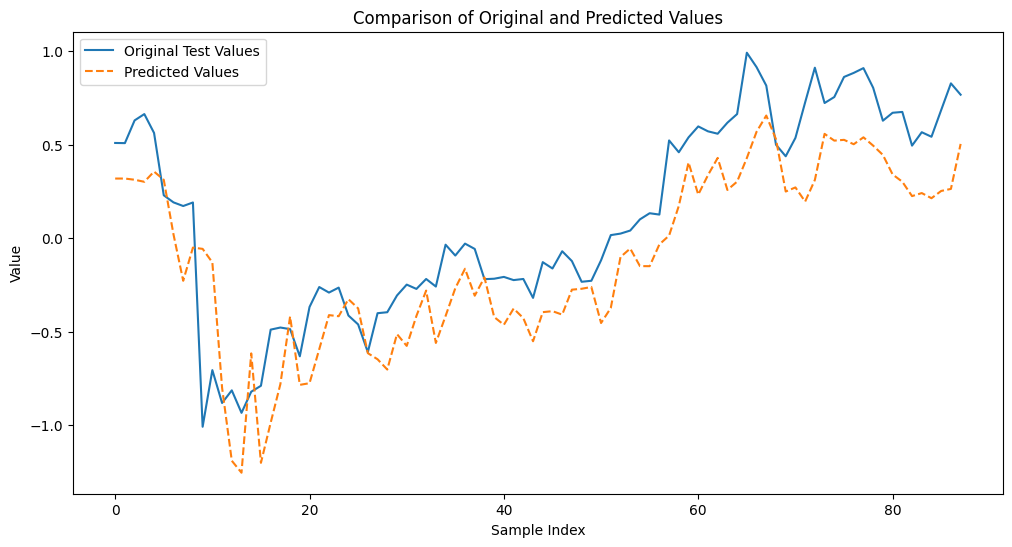

In [102]:
import matplotlib.pyplot as plt
import numpy as np

model_days.eval()

true_values = []
predictions = []

with torch.no_grad():
    for inputs, targets in test_loader_days:
        inputs = inputs.to(device)
        outputs = model_days(inputs)
        true_values.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy())

true_values = np.array(true_values)
predictions = np.array(predictions)

plt.figure(figsize=(12, 6))
plt.plot(true_values, label="Original Test Values")
plt.plot(predictions, label="Predicted Values", linestyle="--")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Comparison of Original and Predicted Values")
plt.legend()
plt.show()

In [103]:
input_dim = 9
hidden_dim = 128
learning_rate = 0.01
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_hours = LSTMModel(
    input_size=input_dim,
    hidden_size=[hidden_dim],
    output_size=1,
    n_layers=2,
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_hours.parameters(), lr=learning_rate)

(
    epoch_log,
    train_mse_log,
    val_mse_log,
    test_mse_log,
    train_r2_log,
    val_r2_log,
    test_r2_log,
) = fit(
    model_hours,
    optimizer,
    criterion,
    train_loader_hours,
    val_loader_hours,
    test_loader_hours,
    epochs=10,
)

  0%|          | 0/467 [00:00<?, ?it/s]

100%|██████████| 467/467 [00:08<00:00, 56.61it/s]


Epoch 0: train MSE = 0.900 (R2: 0.100), validation MSE = 0.257 (R2: -0.445)Test MSE = 0.244 (R2: 0.072)


100%|██████████| 467/467 [00:06<00:00, 72.28it/s]


Epoch 1: train MSE = 0.420 (R2: 0.580), validation MSE = 0.017 (R2: 0.906)Test MSE = 0.053 (R2: 0.800)


100%|██████████| 467/467 [00:18<00:00, 25.65it/s]


Epoch 2: train MSE = 0.240 (R2: 0.760), validation MSE = 0.031 (R2: 0.823)Test MSE = 0.051 (R2: 0.807)


100%|██████████| 467/467 [00:08<00:00, 53.71it/s]


Epoch 3: train MSE = 0.188 (R2: 0.812), validation MSE = 0.025 (R2: 0.858)Test MSE = 0.054 (R2: 0.793)


100%|██████████| 467/467 [00:10<00:00, 43.48it/s]


Epoch 4: train MSE = 0.192 (R2: 0.808), validation MSE = 0.052 (R2: 0.709)Test MSE = 0.081 (R2: 0.691)


100%|██████████| 467/467 [00:10<00:00, 45.31it/s]


Epoch 5: train MSE = 0.195 (R2: 0.805), validation MSE = 0.082 (R2: 0.539)Test MSE = 0.113 (R2: 0.569)


100%|██████████| 467/467 [00:09<00:00, 49.98it/s]


Epoch 6: train MSE = 0.138 (R2: 0.862), validation MSE = 0.042 (R2: 0.762)Test MSE = 0.070 (R2: 0.732)


100%|██████████| 467/467 [00:11<00:00, 42.12it/s]


Epoch 7: train MSE = 0.115 (R2: 0.885), validation MSE = 0.036 (R2: 0.798)Test MSE = 0.070 (R2: 0.732)


100%|██████████| 467/467 [00:15<00:00, 30.38it/s]


Epoch 8: train MSE = 0.165 (R2: 0.835), validation MSE = 0.060 (R2: 0.664)Test MSE = 0.082 (R2: 0.687)


100%|██████████| 467/467 [00:11<00:00, 40.78it/s]


Epoch 9: train MSE = 0.107 (R2: 0.893), validation MSE = 0.020 (R2: 0.886)Test MSE = 0.045 (R2: 0.827)


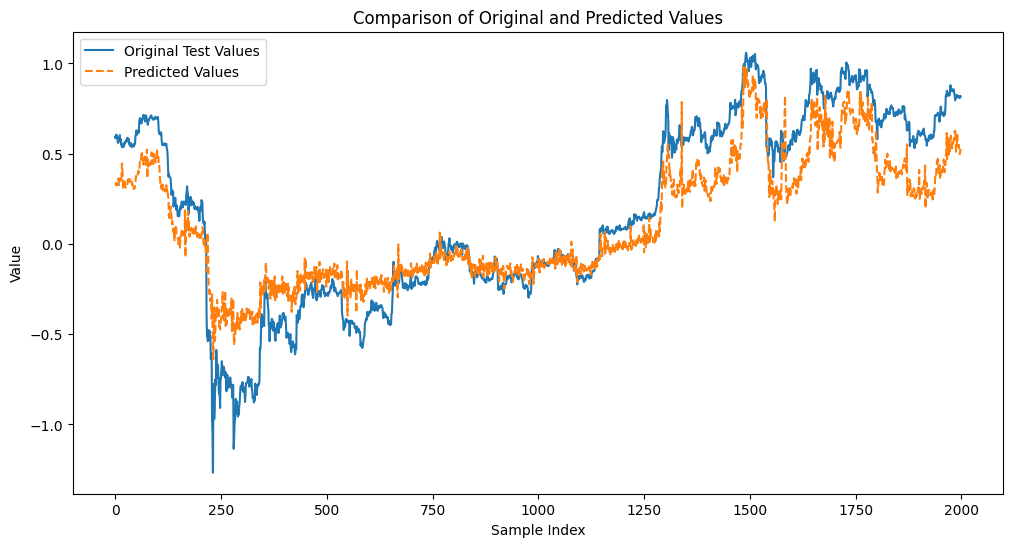

In [104]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

model_hours.eval()

true_values = []
predictions = []

with torch.no_grad():
    for inputs, targets in test_loader_hours:
        inputs = inputs.to(device)
        outputs = model_hours(inputs)
        true_values.extend(targets.cpu().numpy())
        predictions.extend(outputs.cpu().numpy())

true_values = np.array(true_values)
predictions = np.array(predictions)

plt.figure(figsize=(12, 6))
plt.plot(true_values, label="Original Test Values")
plt.plot(predictions, label="Predicted Values", linestyle="--")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Comparison of Original and Predicted Values")
plt.legend()
plt.show()

# LAB 12


## Hiperparametry - długość sekwencji w modelu LSTM


In [149]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def chart_results(
    test_loader: DataLoader,
    model: nn.Module,
):

    model.eval()

    true_values = []
    predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            true_values.extend(targets.cpu().numpy())
            predictions.extend(outputs.cpu().numpy())

    true_values = np.array(true_values)
    predictions = np.array(predictions)

    plt.figure(figsize=(12, 6))
    plt.plot(true_values, label="Original Test Values")
    plt.plot(predictions, label="Predicted Values", linestyle="--")
    plt.xlabel("Sample Index")
    plt.ylabel("Value")
    plt.title("Comparison of Original and Predicted Values")
    plt.legend()
    plt.show()


def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    test_loader: DataLoader,
    input_dim: int = 9,
):

    hidden_dim = 128
    learning_rate = 0.01

    model = LSTMModel(
        input_size=input_dim,
        hidden_size=[hidden_dim],
        output_size=1,
        n_layers=1,
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    (
        epoch_log,
        train_mse_log,
        val_mse_log,
        test_mse_log,
        train_r2_log,
        val_r2_log,
        test_r2_log,
    ) = fit(
        model,
        optimizer,
        criterion,
        train_loader,
        val_loader,
        test_loader,
        epochs=10,
    )

    return (
        epoch_log,
        train_mse_log,
        val_mse_log,
        test_mse_log,
        train_r2_log,
        val_r2_log,
        test_r2_log,
        model,
    )


def test_sequence_len(
    X_train_days: pd.DataFrame,
    y_train_days: pd.Series,
    X_val_days: pd.DataFrame,
    y_val_days: pd.Series,
    X_test_days: pd.DataFrame,
    y_test_days: pd.Series,
    sequence_len: int,
    input_dim: int = 9,
):
    batch_size = 32
    train_dataset_days = TimeSeriesDataset(X_train_days, y_train_days, sequence_len)
    val_dataset_days = TimeSeriesDataset(X_val_days, y_val_days, sequence_len)
    test_dataset_days = TimeSeriesDataset(X_test_days, y_test_days, sequence_len)

    train_loader_days = DataLoader(
        train_dataset_days, batch_size=batch_size, shuffle=False
    )
    val_loader_days = DataLoader(val_dataset_days, batch_size=batch_size, shuffle=False)
    test_loader_days = DataLoader(
        test_dataset_days, batch_size=batch_size, shuffle=False
    )

    (
        epoch_log,
        train_mse_log,
        val_mse_log,
        test_mse_log,
        train_r2_log,
        val_r2_log,
        test_r2_log,
        model,
    ) = train(train_loader_days, val_loader_days, test_loader_days, input_dim)

    chart_results(test_loader_days, model)
    return (
        train_mse_log,
        val_mse_log,
        test_mse_log,
        train_r2_log,
        val_r2_log,
        test_r2_log,
    )

/home/piotr/projects/ai/gsn-l/lab-11/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
100%|██████████| 22/22 [00:00<00:00, 128.19it/s]


Epoch 0: train MSE = 0.463 (R2: 0.537), validation MSE = 0.263 (R2: -0.515)Test MSE = 0.226 (R2: 0.189)


100%|██████████| 22/22 [00:00<00:00, 221.60it/s]


Epoch 1: train MSE = 0.440 (R2: 0.560), validation MSE = 0.152 (R2: 0.124)Test MSE = 0.186 (R2: 0.333)


100%|██████████| 22/22 [00:00<00:00, 167.91it/s]


Epoch 2: train MSE = 0.086 (R2: 0.914), validation MSE = 0.062 (R2: 0.640)Test MSE = 0.164 (R2: 0.411)


100%|██████████| 22/22 [00:00<00:00, 183.08it/s]


Epoch 3: train MSE = 0.110 (R2: 0.890), validation MSE = 0.016 (R2: 0.905)Test MSE = 0.042 (R2: 0.849)


100%|██████████| 22/22 [00:00<00:00, 57.79it/s]


Epoch 4: train MSE = 0.053 (R2: 0.947), validation MSE = 0.016 (R2: 0.910)Test MSE = 0.042 (R2: 0.851)


100%|██████████| 22/22 [00:00<00:00, 96.09it/s]


Epoch 5: train MSE = 0.141 (R2: 0.859), validation MSE = 0.149 (R2: 0.142)Test MSE = 0.147 (R2: 0.471)


100%|██████████| 22/22 [00:00<00:00, 147.74it/s]


Epoch 6: train MSE = 0.107 (R2: 0.893), validation MSE = 0.043 (R2: 0.753)Test MSE = 0.070 (R2: 0.749)


100%|██████████| 22/22 [00:00<00:00, 144.36it/s]


Epoch 7: train MSE = 0.165 (R2: 0.835), validation MSE = 0.048 (R2: 0.725)Test MSE = 0.078 (R2: 0.721)


100%|██████████| 22/22 [00:00<00:00, 100.72it/s]


Epoch 8: train MSE = 0.254 (R2: 0.746), validation MSE = 0.029 (R2: 0.834)Test MSE = 0.062 (R2: 0.776)


100%|██████████| 22/22 [00:00<00:00, 82.41it/s]


Epoch 9: train MSE = 0.066 (R2: 0.934), validation MSE = 0.061 (R2: 0.647)Test MSE = 0.079 (R2: 0.717)


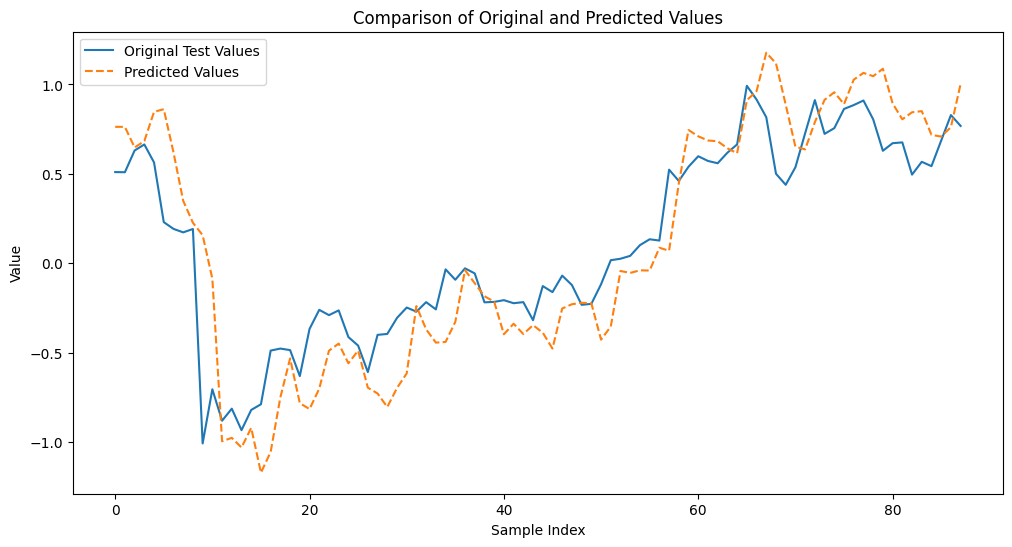

/home/piotr/projects/ai/gsn-l/lab-11/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
100%|██████████| 22/22 [00:00<00:00, 64.67it/s]


Epoch 0: train MSE = 0.388 (R2: 0.612), validation MSE = 0.190 (R2: -0.094)Test MSE = 0.647 (R2: -1.324)


100%|██████████| 22/22 [00:00<00:00, 74.12it/s]


Epoch 1: train MSE = 0.253 (R2: 0.747), validation MSE = 0.052 (R2: 0.698)Test MSE = 0.159 (R2: 0.431)


100%|██████████| 22/22 [00:00<00:00, 118.34it/s]


Epoch 2: train MSE = 0.414 (R2: 0.586), validation MSE = 0.080 (R2: 0.538)Test MSE = 0.150 (R2: 0.462)


100%|██████████| 22/22 [00:00<00:00, 142.61it/s]


Epoch 3: train MSE = 0.177 (R2: 0.823), validation MSE = 0.049 (R2: 0.716)Test MSE = 0.097 (R2: 0.653)


100%|██████████| 22/22 [00:00<00:00, 114.70it/s]


Epoch 4: train MSE = 0.211 (R2: 0.789), validation MSE = 0.081 (R2: 0.530)Test MSE = 0.098 (R2: 0.650)


100%|██████████| 22/22 [00:00<00:00, 134.89it/s]


Epoch 5: train MSE = 0.194 (R2: 0.806), validation MSE = 0.035 (R2: 0.800)Test MSE = 0.069 (R2: 0.752)


100%|██████████| 22/22 [00:00<00:00, 73.73it/s]


Epoch 6: train MSE = 0.109 (R2: 0.891), validation MSE = 0.034 (R2: 0.807)Test MSE = 0.064 (R2: 0.769)


100%|██████████| 22/22 [00:00<00:00, 89.95it/s]


Epoch 7: train MSE = 0.116 (R2: 0.884), validation MSE = 0.055 (R2: 0.681)Test MSE = 0.073 (R2: 0.737)


100%|██████████| 22/22 [00:00<00:00, 121.13it/s]


Epoch 8: train MSE = 0.178 (R2: 0.822), validation MSE = 0.035 (R2: 0.799)Test MSE = 0.092 (R2: 0.670)


100%|██████████| 22/22 [00:00<00:00, 80.77it/s]


Epoch 9: train MSE = 0.092 (R2: 0.908), validation MSE = 0.022 (R2: 0.873)Test MSE = 0.063 (R2: 0.774)


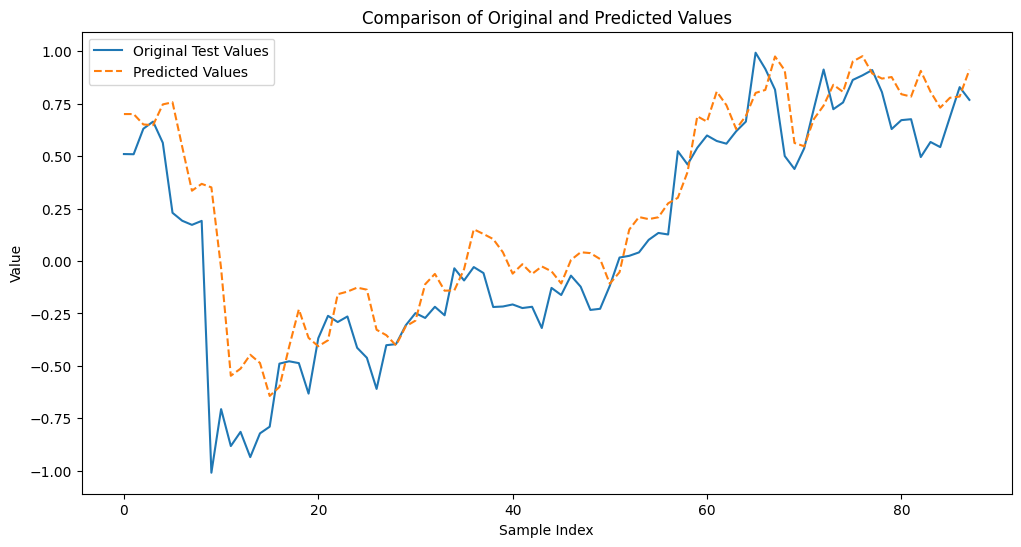

/home/piotr/projects/ai/gsn-l/lab-11/venv/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
100%|██████████| 22/22 [00:00<00:00, 30.85it/s]


Epoch 0: train MSE = 0.331 (R2: 0.669), validation MSE = 0.131 (R2: 0.247)Test MSE = 0.377 (R2: -0.353)


100%|██████████| 22/22 [00:00<00:00, 54.76it/s]


Epoch 1: train MSE = 1.087 (R2: -0.087), validation MSE = 0.242 (R2: -0.397)Test MSE = 0.194 (R2: 0.302)


100%|██████████| 22/22 [00:00<00:00, 41.33it/s]


Epoch 2: train MSE = 0.160 (R2: 0.840), validation MSE = 0.122 (R2: 0.298)Test MSE = 0.143 (R2: 0.486)


100%|██████████| 22/22 [00:00<00:00, 36.21it/s]


Epoch 3: train MSE = 0.106 (R2: 0.894), validation MSE = 0.059 (R2: 0.662)Test MSE = 0.066 (R2: 0.764)


100%|██████████| 22/22 [00:00<00:00, 41.35it/s]


Epoch 4: train MSE = 0.133 (R2: 0.867), validation MSE = 0.034 (R2: 0.806)Test MSE = 0.069 (R2: 0.751)


100%|██████████| 22/22 [00:00<00:00, 41.16it/s]


Epoch 5: train MSE = 0.149 (R2: 0.851), validation MSE = 0.025 (R2: 0.853)Test MSE = 0.058 (R2: 0.792)


100%|██████████| 22/22 [00:00<00:00, 28.59it/s]


Epoch 6: train MSE = 0.233 (R2: 0.767), validation MSE = 0.192 (R2: -0.109)Test MSE = 0.165 (R2: 0.408)


100%|██████████| 22/22 [00:00<00:00, 49.30it/s]


Epoch 7: train MSE = 0.126 (R2: 0.874), validation MSE = 0.076 (R2: 0.562)Test MSE = 0.099 (R2: 0.645)


100%|██████████| 22/22 [00:00<00:00, 36.29it/s]


Epoch 8: train MSE = 0.106 (R2: 0.894), validation MSE = 0.059 (R2: 0.662)Test MSE = 0.086 (R2: 0.690)


100%|██████████| 22/22 [00:00<00:00, 46.34it/s]


Epoch 9: train MSE = 0.274 (R2: 0.726), validation MSE = 0.135 (R2: 0.222)Test MSE = 0.129 (R2: 0.539)


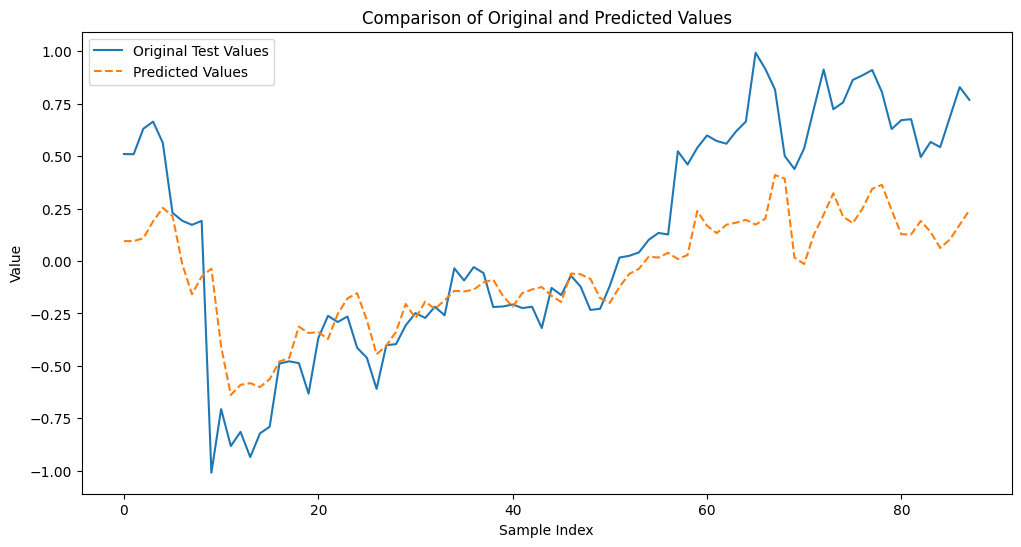

[{'sequence_len': 2, 'mse': 0.07880905270576477, 'r2': 0.7170791678854211},
 {'sequence_len': 10, 'mse': 0.06284134089946747, 'r2': 0.7744025175890988},
 {'sequence_len': 50, 'mse': 0.12853498756885529, 'r2': 0.5385653223413354}]

In [115]:
sequence_lengths = [2, 10, 50]

res = []
for sequence_len in sequence_lengths:
    (
        train_mse_log,
        val_mse_log,
        test_mse_log,
        train_r2_log,
        val_r2_log,
        test_r2_log,
    ) = test_sequence_len(
        X_train_days,
        y_train_days,
        X_val_days,
        y_val_days,
        X_test_days,
        y_test_days,
        sequence_len=sequence_len,
    )

    last_mse = test_mse_log[-1]
    last_r2 = test_r2_log[-1]

    res.append(
        {
            "sequence_len": sequence_len,
            "mse": last_mse,
            "r2": last_r2,
        }
    )


display(res)

Best results for sequence_len=10 (lowest mse, highest r2)


## Przetwarzanie wstępne

2. Zamiana wartości liczbowej na procentową zmianę względem poprzedniego kursu.


In [146]:
import copy

merged_data_days = pd.read_csv("merged_data_days.csv")
merged_data_days_pct = copy.deepcopy(merged_data_days)
merged_data_days_pct["close"] = merged_data_days_pct["close"].pct_change()

merged_data_days_pct.loc[0, "close"] = 0

train_data_days_pct, val_data_days_pct, test_data_days_pct = split_data(
    merged_data_days_pct
)
print(len(train_data_days_pct), len(val_data_days_pct), len(test_data_days_pct))
display(merged_data_days_pct)

703 88 88


,Unnamed: 0,timestamp,open,high,low,close,volume,likes,retweets,emotion,emoji
0,2018-01-02,1514851200,13394.20,15257.53,12910.58,0.000000,16299.669303,1.970263,0.704357,0.486169,3.231328
1,2018-01-03,1514937600,14670.96,15500.00,14546.28,0.032474,12275.001197,1.939863,1.076117,0.454639,3.082818
2,2018-01-04,1515024000,15155.62,15430.27,14192.37,-0.000788,15004.018593,3.431941,1.209056,0.470716,3.070499
3,2018-01-05,1515110400,15143.67,17200.00,14810.00,0.117827,16248.914680,2.334383,1.049493,0.478664,3.154774
4,2018-01-06,1515196800,16927.99,17234.99,16220.00,0.013095,9501.016755,2.473111,1.708645,0.507148,3.126163
...,...,...,...,...,...,...,...,...,...,...,...
874,2020-05-25,1590364800,8710.12,8984.16,8630.00,0.021195,8919.923790,3.861104,1.468256,0.729723,3.189168
875,2020-05-26,1590451200,8903.22,9012.00,8690.00,-0.007037,5923.005237,4.152313,1.959330,0.724349,3.327751
876,2020-05-27,1590537600,8835.79,9230.21,8810.99,0.041748,6867.671019,5.665282,1.283411,0.710237,3.213780
877,2020-05-28,1590624000,9209.99,9625.01,9105.79,0.039889,11523.408895,4.337030,1.965595,0.691716,3.136034


/tmp/ipykernel_1950646/2634752345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_days_pct.dropna(inplace=True)
/tmp/ipykernel_1950646/2634752345.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data_days_pct.dropna(inplace=True)
/tmp/ipykernel_1950646/2634752345.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_days_pct.dropna(inplace=True)
/home/piotr/projects/ai/gsn-l/lab-11/venv/lib/python3.12/site

100%|██████████| 22/22 [00:01<00:00, 15.56it/s]


Epoch 0: train MSE = 0.993 (R2: 0.007), validation MSE = 0.542 (R2: -0.062)Test MSE = 2.376 (R2: -0.011)


100%|██████████| 22/22 [00:00<00:00, 121.28it/s]


Epoch 1: train MSE = 0.979 (R2: 0.021), validation MSE = 0.524 (R2: -0.026)Test MSE = 2.345 (R2: 0.002)


100%|██████████| 22/22 [00:00<00:00, 127.18it/s]


Epoch 2: train MSE = 0.971 (R2: 0.029), validation MSE = 0.523 (R2: -0.024)Test MSE = 2.342 (R2: 0.003)


100%|██████████| 22/22 [00:00<00:00, 143.90it/s]


Epoch 3: train MSE = 0.998 (R2: 0.002), validation MSE = 0.544 (R2: -0.066)Test MSE = 2.364 (R2: -0.006)


100%|██████████| 22/22 [00:00<00:00, 134.11it/s]


Epoch 4: train MSE = 1.019 (R2: -0.019), validation MSE = 0.567 (R2: -0.111)Test MSE = 2.471 (R2: -0.052)


100%|██████████| 22/22 [00:00<00:00, 42.87it/s]


Epoch 5: train MSE = 0.983 (R2: 0.017), validation MSE = 0.544 (R2: -0.066)Test MSE = 2.353 (R2: -0.001)


100%|██████████| 22/22 [00:00<00:00, 115.83it/s]


Epoch 6: train MSE = 0.948 (R2: 0.052), validation MSE = 0.585 (R2: -0.147)Test MSE = 2.460 (R2: -0.047)


100%|██████████| 22/22 [00:00<00:00, 117.54it/s]


Epoch 7: train MSE = 0.970 (R2: 0.030), validation MSE = 0.618 (R2: -0.211)Test MSE = 2.586 (R2: -0.101)


100%|██████████| 22/22 [00:00<00:00, 101.84it/s]


Epoch 8: train MSE = 0.977 (R2: 0.023), validation MSE = 0.524 (R2: -0.027)Test MSE = 2.433 (R2: -0.035)


100%|██████████| 22/22 [00:00<00:00, 111.51it/s]


Epoch 9: train MSE = 0.947 (R2: 0.053), validation MSE = 0.570 (R2: -0.116)Test MSE = 2.417 (R2: -0.029)


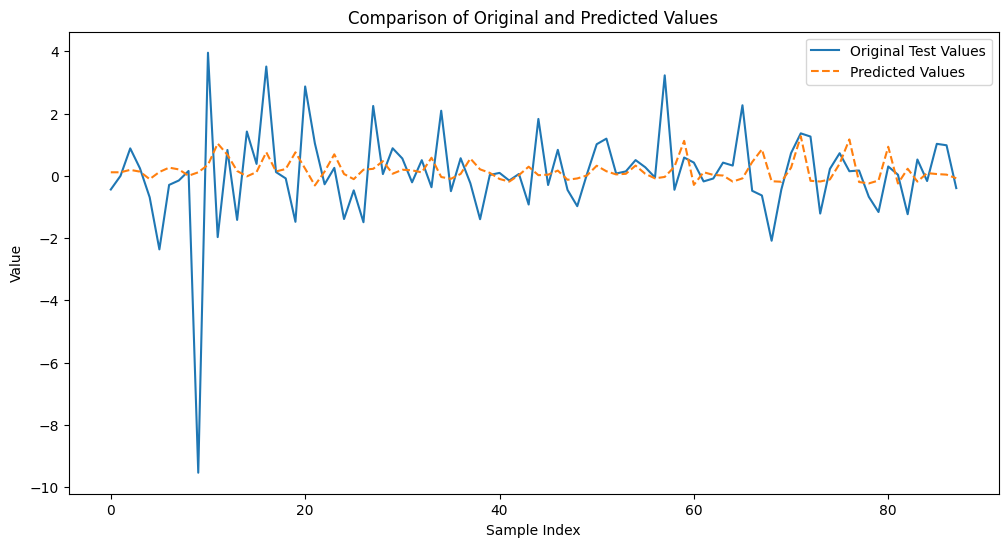

In [144]:
# test with sequence len of 10
train_data_days_pct.dropna(inplace=True)
val_data_days_pct.dropna(inplace=True)
test_data_days_pct.dropna(inplace=True)

X_train_days_pct, y_train_days_pct = split_X_y(train_data_days_pct, "close")
X_val_days_pct, y_val_days_pct = split_X_y(val_data_days_pct, "close")
X_test_days_pct, y_test_days_pct = split_X_y(test_data_days_pct, "close")

X_scaler = StandardScaler()
y_scaler = StandardScaler()

numeric_cols = X_train_days_pct.select_dtypes(include=["number"]).columns

X_train_days_pct = X_scaler.fit_transform(X_train_days_pct[numeric_cols])
y_train_days_pct = y_scaler.fit_transform(y_train_days_pct.values.reshape(-1, 1))

X_val_days_pct = X_scaler.transform(X_val_days_pct[numeric_cols])
y_val_days_pct = y_scaler.transform(y_val_days_pct.values.reshape(-1, 1))

X_test_days_pct = X_scaler.transform(X_test_days_pct[numeric_cols])
y_test_days_pct = y_scaler.transform(y_test_days_pct.values.reshape(-1, 1))


(
    train_mse_log,
    val_mse_log,
    test_mse_log,
    train_r2_log,
    val_r2_log,
    test_r2_log,
) = test_sequence_len(
    X_train_days_pct,
    y_train_days_pct,
    X_val_days_pct,
    y_val_days_pct,
    X_test_days_pct,
    y_test_days_pct,
    sequence_len=10,
)

In [145]:
# results
print("Test MSE:", test_mse_log[-1])
print("Test R2:", test_r2_log[-1])

Test MSE: 2.4168875217437744
Test R2: -0.028650308284250636


Results for standard version:

- Test MSE: 0.095
- Test R2: 0.658


## Wymiary afektywne


703 88 88


,Unnamed: 0,timestamp,open,high,low,close,volume,likes,retweets
0,2018-01-02,1514851200,13394.20,15257.53,12910.58,14678.94,16299.669303,1.970263,0.704357
1,2018-01-03,1514937600,14670.96,15500.00,14546.28,15155.62,12275.001197,1.939863,1.076117
2,2018-01-04,1515024000,15155.62,15430.27,14192.37,15143.67,15004.018593,3.431941,1.209056
3,2018-01-05,1515110400,15143.67,17200.00,14810.00,16928.00,16248.914680,2.334383,1.049493
4,2018-01-06,1515196800,16927.99,17234.99,16220.00,17149.67,9501.016755,2.473111,1.708645
...,...,...,...,...,...,...,...,...,...
874,2020-05-25,1590364800,8710.12,8984.16,8630.00,8903.56,8919.923790,3.861104,1.468256
875,2020-05-26,1590451200,8903.22,9012.00,8690.00,8840.91,5923.005237,4.152313,1.959330
876,2020-05-27,1590537600,8835.79,9230.21,8810.99,9210.00,6867.671019,5.665282,1.283411
877,2020-05-28,1590624000,9209.99,9625.01,9105.79,9577.38,11523.408895,4.337030,1.965595


/tmp/ipykernel_1950646/2212616002.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_days_no_aff.dropna(inplace=True)
/tmp/ipykernel_1950646/2212616002.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data_days_no_aff.dropna(inplace=True)
/tmp/ipykernel_1950646/2212616002.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_days_no_aff.dropna(inplace=True)
/home/piotr/projects/ai/gsn-l/lab-11/venv/lib/pyt

Epoch 0: train MSE = 0.314 (R2: 0.686), validation MSE = 0.185 (R2: -0.069)Test MSE = 0.433 (R2: -0.555)


100%|██████████| 22/22 [00:00<00:00, 98.34it/s]


Epoch 1: train MSE = 0.233 (R2: 0.767), validation MSE = 0.027 (R2: 0.846)Test MSE = 0.146 (R2: 0.477)


100%|██████████| 22/22 [00:00<00:00, 70.23it/s]


Epoch 2: train MSE = 0.682 (R2: 0.318), validation MSE = 0.103 (R2: 0.403)Test MSE = 0.103 (R2: 0.632)


100%|██████████| 22/22 [00:00<00:00, 103.06it/s]


Epoch 3: train MSE = 0.211 (R2: 0.789), validation MSE = 0.070 (R2: 0.596)Test MSE = 0.177 (R2: 0.366)


100%|██████████| 22/22 [00:00<00:00, 138.29it/s]


Epoch 4: train MSE = 0.117 (R2: 0.883), validation MSE = 0.036 (R2: 0.790)Test MSE = 0.087 (R2: 0.689)


100%|██████████| 22/22 [00:00<00:00, 116.48it/s]


Epoch 5: train MSE = 0.214 (R2: 0.786), validation MSE = 0.164 (R2: 0.055)Test MSE = 0.200 (R2: 0.283)


100%|██████████| 22/22 [00:00<00:00, 147.82it/s]


Epoch 6: train MSE = 0.344 (R2: 0.656), validation MSE = 0.033 (R2: 0.811)Test MSE = 0.101 (R2: 0.638)


100%|██████████| 22/22 [00:00<00:00, 112.57it/s]


Epoch 7: train MSE = 0.074 (R2: 0.926), validation MSE = 0.045 (R2: 0.743)Test MSE = 0.094 (R2: 0.662)


100%|██████████| 22/22 [00:00<00:00, 121.81it/s]


Epoch 8: train MSE = 0.141 (R2: 0.859), validation MSE = 0.058 (R2: 0.664)Test MSE = 0.082 (R2: 0.706)


100%|██████████| 22/22 [00:00<00:00, 118.15it/s]


Epoch 9: train MSE = 0.140 (R2: 0.860), validation MSE = 0.038 (R2: 0.778)Test MSE = 0.081 (R2: 0.710)


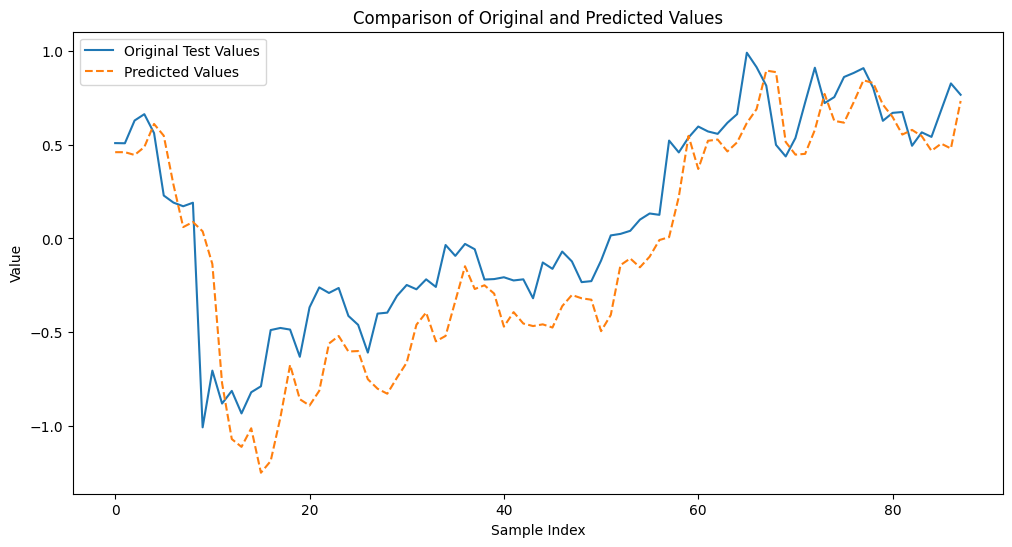

In [150]:
import copy

merged_data_days = pd.read_csv("merged_data_days.csv")
merged_data_days_no_aff = copy.deepcopy(merged_data_days)

merged_data_days_no_aff.drop(columns=["emoji"], inplace=True)
merged_data_days_no_aff.drop(columns=["emotion"], inplace=True)


train_data_days_no_aff, val_data_days_no_aff, test_data_days_no_aff = split_data(
    merged_data_days_no_aff
)
print(
    len(train_data_days_no_aff), len(val_data_days_no_aff), len(test_data_days_no_aff)
)
display(merged_data_days_no_aff)


# test with sequence len of 10
train_data_days_no_aff.dropna(inplace=True)
val_data_days_no_aff.dropna(inplace=True)
test_data_days_no_aff.dropna(inplace=True)

X_train_days_no_aff, y_train_days_no_aff = split_X_y(train_data_days_no_aff, "close")
X_val_days_no_aff, y_val_days_no_aff = split_X_y(val_data_days_no_aff, "close")
X_test_days_no_aff, y_test_days_no_aff = split_X_y(test_data_days_no_aff, "close")

X_scaler = StandardScaler()
y_scaler = StandardScaler()

numeric_cols = X_train_days_no_aff.select_dtypes(include=["number"]).columns

X_train_days_no_aff = X_scaler.fit_transform(X_train_days_no_aff[numeric_cols])
y_train_days_no_aff = y_scaler.fit_transform(y_train_days_no_aff.values.reshape(-1, 1))

X_val_days_no_aff = X_scaler.transform(X_val_days_no_aff[numeric_cols])
y_val_days_no_aff = y_scaler.transform(y_val_days_no_aff.values.reshape(-1, 1))

X_test_days_no_aff = X_scaler.transform(X_test_days_no_aff[numeric_cols])
y_test_days_no_aff = y_scaler.transform(y_test_days_no_aff.values.reshape(-1, 1))


(
    train_mse_log,
    val_mse_log,
    test_mse_log,
    train_r2_log,
    val_r2_log,
    test_r2_log,
) = test_sequence_len(
    X_train_days_no_aff,
    y_train_days_no_aff,
    X_val_days_no_aff,
    y_val_days_no_aff,
    X_test_days_no_aff,
    y_test_days_no_aff,
    sequence_len=10,
    input_dim=7,
)

In [151]:
print("Test MSE:", test_mse_log[-1])
print("Test R2:", test_r2_log[-1])

Test MSE: 0.08077172935009003
Test R2: 0.7100332232960673


Results for standard version:

- Test MSE: 0.095
- Test R2: 0.658
